## Predicting the Minority Percentage for Public High Schools
**This notebook explores predicting the Minority Percentage for public high schools in North Carolina.** 
* Using **NO** racial composition data, can we predict the minority percentage for a public high school?
* The North Carolina Educational Attainment Data Repository for Machine Learning is located on Github at: https://github.com/jakemdrew/EducationDataNC 
* Since the response variable is highly unbalanced we choose to set the *class_weight* parameter to 'balanced.  While this lowers overall accuracy, it almost doubles recall which is the model's ability to accurately identify highly segeregated schools


**For documentation on various Generalized Linear Models in Sklearn see:**
* http://scikit-learn.org/stable/modules/linear_model.html
* https://stackoverflow.com/questions/33845539/modelling-probabilities-in-a-regularized-logistic-regression-model-in-python

In [33]:
#import required Libraries
import pandas as pd
import numpy as np

#The 'path' variable may also be a URL pointing to the proper raw file path on github: 
#path="https://raw.githubusercontent.com/jakemdrew/EducationDataNC/master/2017/Machine%20Learning%20Datasets/PublicHighSchools2017_ML.csv"

path="C:/Users/Jake/Documents/GitHub/EducationDataNC/2015/Machine Learning Datasets/PublicHighSchools2015_ML.csv"
schData=pd.read_csv(path, low_memory=False)

#inspect data 
schData.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Columns: 412 entries, student_num to unit_code
dtypes: float64(323), int64(89)
memory usage: 1.5 MB


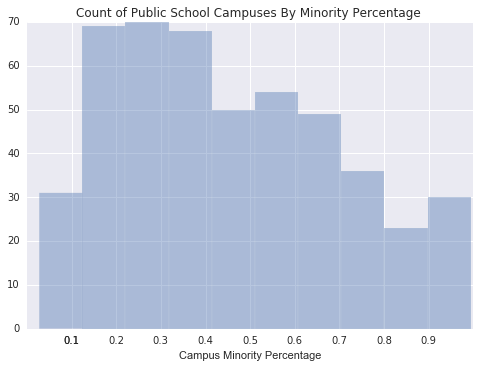

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
hst = sns.distplot(schData['MinorityPct'], kde=False)
hst.set_xlabel("Campus Minority Percentage")
#Assign output of plt.xticks() to x to surpress xticks() function output 
_ = plt.xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10])
_ = plt.title('Count of Public School Campuses By Minority Percentage ')

In [2]:
#Delete all racial composition data from our dataset. 
raceCompositionFields = ['Indian Male','Asian Male','Hispanic Male','Black Male','White Male'
                         ,'Pacific Island Male','Pacific Island Female','Two or  More Male','Two or  More Female'
                         ,'Pacific Island','Majority_Minority','White_Pct','Two or More']

RaceCols = schData.columns[(schData.columns.str.lower().str.contains('indian')) | 
                           (schData.columns.str.lower().str.contains('asian')) |
                           (schData.columns.str.lower().str.contains('hispanic')) |
                           (schData.columns.str.lower().str.contains('black')) |
                           (schData.columns.str.lower().str.contains('white')) |
                           (schData.columns.str.lower().str.contains('pacific island')) |
                           (schData.columns.str.lower().str.contains('two or  more')) |
                           (schData.columns.str.lower().str.contains('minority'))]
RaceCols

Index([u'ACTCompositeScore_UNCMin_AmericanIndian',
       u'ACTEnglish_ACTBenchmark_AmericanIndian',
       u'ACTMath_ACTBenchmark_AmericanIndian',
       u'ACTReading_ACTBenchmark_AmericanIndian',
       u'ACTScience_ACTBenchmark_AmericanIndian',
       u'ACTSubtests_BenchmarksMet_AmericanIndian',
       u'ACTWorkKeys_SilverPlus_AmericanIndian',
       u'ACTWriting_ACTBenchmark_AmericanIndian',
       u'EOCBiology_CACR_AmericanIndian', u'EOCEnglish2_CACR_AmericanIndian',
       u'EOCMathI_CACR_AmericanIndian', u'EOCSubjects_CACR_AmericanIndian',
       u'GraduationRate_4yr_AmericanIndian',
       u'GraduationRate_5yr_AmericanIndian', u'ACTCompositeScore_UNCMin_Asian',
       u'ACTReading_ACTBenchmark_Asian', u'ACTScience_ACTBenchmark_Asian',
       u'ACTSubtests_BenchmarksMet_Asian', u'ACTWorkKeys_SilverPlus_Asian',
       u'ACTWriting_ACTBenchmark_Asian', u'EOCBiology_CACR_Asian',
       u'EOCEnglish2_CACR_Asian', u'EOCMathI_CACR_Asian',
       u'EOCSubjects_CACR_Asian', u'Graduation

In [3]:
# create x explanatory and y response variables for regression
Y_MinorityPct = schData['MinorityPct'] 
Y = Y_MinorityPct

#Delete all racial composition data from our dataset.
X_highSchools = schData.drop(RaceCols, axis=1)

#inspect data 
X_highSchools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Columns: 327 entries, student_num to unit_code
dtypes: float64(238), int64(89)
memory usage: 1.2 MB


In [4]:
#Scale dataset converting to standard normally distributed data 
# (e.g. Gaussian with 0 mean and unit variance).
#from sklearn.preprocessing import StandardScaler

#Fit to data for scaling
#scaler = StandardScaler()
#scaler.fit(X_highSchools)

#Transform training data to z-scores
#This makes our model's coefficients take on the same scale for accurate feature importance analisys 
#X_highSchools = scaler.transform(X_highSchools)

## Cross Validation
**Cross validation is performed using repeated holdout using ShuffleSplit()**
* Ten folds are used
* The split is: 90% training data and 10% test data
* A random seed is set so the same random test and training splits are used each time cross validation is performed.

In [5]:
#Divide data into test and training splits
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.10, random_state=0)

## Classifier Evaluation
** The following function performs cross validation using cross_validate() for classification estimators and returns accuracy, precision, and recall.** 

In [6]:
from sklearn.model_selection import cross_validate

def EvaluateClassifierEstimator(classifierEstimator, X, y, cv):
   
    #Perform cross validation 
    scores = cross_validate(classifierEstimator, X_highSchools, Y, scoring=['accuracy','precision','recall']
                            , cv=cv, return_train_score=True)

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Recavg = scores['test_recall'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average recall for all cv folds is: \t\t\t {Recavg:.5}"

    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Recavg=Recavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']

    return scoresResults

def EvaluateClassifierEstimator2(classifierEstimator, X, y, cv):
    
    #Perform cross validation 
    from sklearn.model_selection import cross_val_predict
    predictions = cross_val_predict(classifierEstimator, X_highSchools, Y, cv=cv)
    
    #model evaluation 
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    
    #pass true test set values and predictions to classification_report
    classReport = classification_report(Y,predictions)
    confMat = confusion_matrix(Y,predictions)
    acc = accuracy_score(Y,predictions)
    
    print classReport
    print confMat
    print acc

## Minority Percent - Logistic Regression 
**This model uses a Logistic Regression to classify public high schools as greater than 40% to 90% minorities. Please see documentation here: **
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [7]:
#Convert Y to a binary response variable 
Y = Y_MinorityPct >= 0.80

#Logisitic regression 10-fold cross-validation 
from sklearn.linear_model import LogisticRegression
regEstimator = LogisticRegression()


parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced'] #,'none']
              ,'random_state': [0]
              ,'solver': ['lbfgs']
              ,'max_iter':[100,500]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools, Y)

Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   17.9s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:   43.5s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['lbfgs'], 'max_iter': [100, 500], 'penalty': ['l2'], 'random_state': [0], 'class_weight': ['balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [8]:
#Display the best estimator parameters
regGridSearch.best_estimator_

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=500,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [9]:
#Convert Y to a binary response variable 
Y = Y_MinorityPct >= 0.40

#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_highSchools, Y, cv)

The average accuracy for all cv folds is: 			 0.76875
The average precision for all cv folds is: 			 0.79069
The average recall for all cv folds is: 			 0.76578
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.833333,0.809524,0.809524
1,0.854167,0.840000,0.875000
2,0.770833,0.851852,0.766667
3,0.562500,0.565217,0.541667
4,0.666667,0.730769,0.678571
5,0.833333,0.875000,0.807692
6,0.770833,0.777778,0.807692
7,0.791667,0.880000,0.758621
8,0.854167,0.814815,0.916667
9,0.750000,0.761905,0.695652


In [10]:
#Convert Y to a binary response variable 
Y = Y_MinorityPct >= 0.50

#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_highSchools, Y, cv)

The average accuracy for all cv folds is: 			 0.81042
The average precision for all cv folds is: 			 0.78308
The average recall for all cv folds is: 			 0.74388
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.812500,0.647059,0.785714
1,0.875000,0.833333,0.909091
2,0.833333,0.863636,0.791667
3,0.729167,0.666667,0.555556
4,0.729167,0.714286,0.681818
5,0.791667,0.812500,0.650000
6,0.854167,0.826087,0.863636
7,0.812500,0.904762,0.730769
8,0.854167,0.812500,0.764706
9,0.812500,0.750000,0.705882


In [11]:
EvaluateClassifierEstimator2(classifierEst, X_highSchools, Y, 10)

             precision    recall  f1-score   support

      False       0.84      0.80      0.82       279
       True       0.74      0.79      0.76       201

avg / total       0.80      0.79      0.79       480

[[222  57]
 [ 42 159]]
0.79375


In [12]:
#Convert Y to a binary response variable 
Y = Y_MinorityPct >= 0.60

#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_highSchools, Y, cv)

The average accuracy for all cv folds is: 			 0.82292
The average precision for all cv folds is: 			 0.64769
The average recall for all cv folds is: 			 0.76117
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.875000,0.692308,0.818182
1,0.854167,0.800000,0.842105
2,0.791667,0.600000,0.857143
3,0.812500,0.600000,0.545455
4,0.812500,0.636364,0.933333
5,0.833333,0.642857,0.750000
6,0.791667,0.636364,0.875000
7,0.833333,0.785714,0.687500
8,0.812500,0.500000,0.666667
9,0.812500,0.583333,0.636364


In [13]:
EvaluateClassifierEstimator2(classifierEst, X_highSchools, Y, 10)

             precision    recall  f1-score   support

      False       0.90      0.81      0.85       338
       True       0.63      0.80      0.71       142

avg / total       0.82      0.80      0.81       480

[[273  65]
 [ 29 113]]
0.8041666666666667


**The next model uses a Logistic Regression to classify public high schools as greater than 90% minority**

In [14]:
#Convert Y to a binary response variable 
Y = Y_MinorityPct >= 0.70

#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_highSchools, Y, cv)

The average accuracy for all cv folds is: 			 0.83958
The average precision for all cv folds is: 			 0.54319
The average recall for all cv folds is: 			 0.77931
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.895833,0.636364,0.875000
1,0.875000,0.812500,0.812500
2,0.833333,0.615385,0.727273
3,0.854167,0.333333,0.750000
4,0.729167,0.428571,0.545455
5,0.833333,0.545455,0.666667
6,0.770833,0.444444,0.888889
7,0.812500,0.571429,0.727273
8,0.875000,0.444444,0.800000
9,0.916667,0.600000,1.000000


In [15]:
EvaluateClassifierEstimator2(classifierEst, X_highSchools, Y, 10)

             precision    recall  f1-score   support

      False       0.95      0.87      0.91       389
       True       0.59      0.82      0.69        91

avg / total       0.89      0.86      0.87       480

[[337  52]
 [ 16  75]]
0.8583333333333333


In [16]:
#Convert Y to a binary response variable 
Y = Y_MinorityPct >= 0.80

#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_highSchools, Y, cv)

The average accuracy for all cv folds is: 			 0.8375
The average precision for all cv folds is: 			 0.38464
The average recall for all cv folds is: 			 0.67917
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.875000,0.500000,0.666667
1,0.833333,0.500000,0.875000
2,0.833333,0.600000,0.600000
3,0.854167,0.000000,0.000000
4,0.833333,0.333333,0.600000
5,0.875000,0.444444,0.800000
6,0.729167,0.235294,1.000000
7,0.791667,0.400000,0.500000
8,0.854167,0.333333,0.750000
9,0.895833,0.500000,1.000000


In [17]:
EvaluateClassifierEstimator2(classifierEst, X_highSchools, Y, 10)

             precision    recall  f1-score   support

      False       0.96      0.86      0.90       427
       True       0.37      0.68      0.48        53

avg / total       0.89      0.84      0.86       480

[[366  61]
 [ 17  36]]
0.8375


In [18]:
#Convert Y to a binary response variable 
Y = Y_MinorityPct >= 0.90

#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_highSchools, Y, cv)

C:\Users\Jake\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


The average accuracy for all cv folds is: 			 0.90417
The average precision for all cv folds is: 			 0.3825
The average recall for all cv folds is: 			 0.70714
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.895833,0.375000,1.000000
1,0.895833,0.500000,1.000000
2,0.895833,0.666667,0.571429
3,0.979167,0.000000,0.000000
4,0.916667,0.400000,0.666667
5,0.916667,0.400000,0.666667
6,0.812500,0.250000,1.000000
7,0.875000,0.333333,0.500000
8,0.937500,0.500000,1.000000
9,0.916667,0.400000,0.666667


In [19]:
EvaluateClassifierEstimator2(classifierEst, X_highSchools, Y, 10)

             precision    recall  f1-score   support

      False       0.97      0.90      0.93       450
       True       0.29      0.63      0.40        30

avg / total       0.93      0.88      0.90       480

[[403  47]
 [ 11  19]]
0.8791666666666667


# Top Performing Model Analisys
## Testing Scaled vs. Unscaled Training Data
**Cross validation is performed using both scaled and unscaled training data.**
* A grid search is also performed on the scaled training data to determine the best parameters to use with the scaled training data.
* We scale the data prior to looking at feature importances.  Since the raw features have different dynamic ranges, scaling the data first allows us to compare the model's coefficients accurately. 
* The scaled data makes more accurate predictions in many cases but not always!

In [20]:
#Scale dataset converting to standard normally distributed data 
# (e.g. Gaussian with 0 mean and unit variance).
from sklearn.preprocessing import StandardScaler

#Fit to data for scaling
scaler = StandardScaler()
scaler.fit(X_highSchools)

#Transform training data to z-scores
#This makes our model's coefficients take on the same scale for accurate feature importance analisys 
X_highSchools_Scl = scaler.transform(X_highSchools)

**In this case, I tested scaling the data before cross validation as well.**

In [21]:
#Convert Y to a binary response variable 
Y = Y_MinorityPct >= 0.9

#Logisitic regression 10-fold cross-validation 
from sklearn.linear_model import LogisticRegression
regEstimator = LogisticRegression()


parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced'] #,'none']
              ,'random_state': [0]
              ,'solver': ['lbfgs']
              ,'max_iter':[100,500]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools_Scl, Y)

Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    9.7s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:   16.4s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['lbfgs'], 'max_iter': [100, 500], 'penalty': ['l2'], 'random_state': [0], 'class_weight': ['balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [22]:
#Display the best estimator parameters
regGridSearch.best_estimator_

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [23]:
#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_highSchools_Scl, Y, cv)

The average accuracy for all cv folds is: 			 0.85833
The average precision for all cv folds is: 			 0.29113
The average recall for all cv folds is: 			 0.67381
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.875000,0.333333,1.000000
1,0.854167,0.416667,1.000000
2,0.875000,0.571429,0.571429
3,0.937500,0.000000,0.000000
4,0.854167,0.250000,0.666667
5,0.895833,0.333333,0.666667
6,0.729167,0.187500,1.000000
7,0.791667,0.200000,0.500000
8,0.875000,0.285714,0.666667
9,0.895833,0.333333,0.666667


In [24]:
EvaluateClassifierEstimator2(classifierEst, X_highSchools_Scl, Y, 10)

             precision    recall  f1-score   support

      False       0.98      0.85      0.91       450
       True       0.25      0.73      0.37        30

avg / total       0.93      0.85      0.88       480

[[384  66]
 [  8  22]]
0.8458333333333333


In [25]:
Y.value_counts()

False    450
True      30
Name: MinorityPct, dtype: int64

## Feature Importance for the Top Performing Model
**Here we look at the features driving the top performing model's decisions.**
* The top performing model predicts the minority percentage of public high schools with 95% accuracy.
* All training data is scaled to remove differences in coefficient scales since many features have different dynamic ranges.
* A final model is created using all the scaled training data.  
* All model coefficients are sorted by absolute value in descending order.
* Sorted coefficient values are plotted showing the top 75 features with the strongest positive and negative correlations. 

In [26]:
#Create a classification estimator with best parameters for cross validation
classifierEst = regGridSearch.best_estimator_

#Fit the model using all of the scaled training data
classifierEst.fit(X_highSchools_Scl, Y)

from sklearn.metrics import confusion_matrix

In [27]:
#Load the model's coefficient weights and feature names into a dataframe sorted by weights
weights = classifierEst.coef_.ravel()
feature_names = X_highSchools.columns.values
linreg_ft_imp_df = pd.DataFrame({'feature_names':feature_names, 'weights':weights, 'absolute_weights': np.abs(weights)})
linreg_ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False )

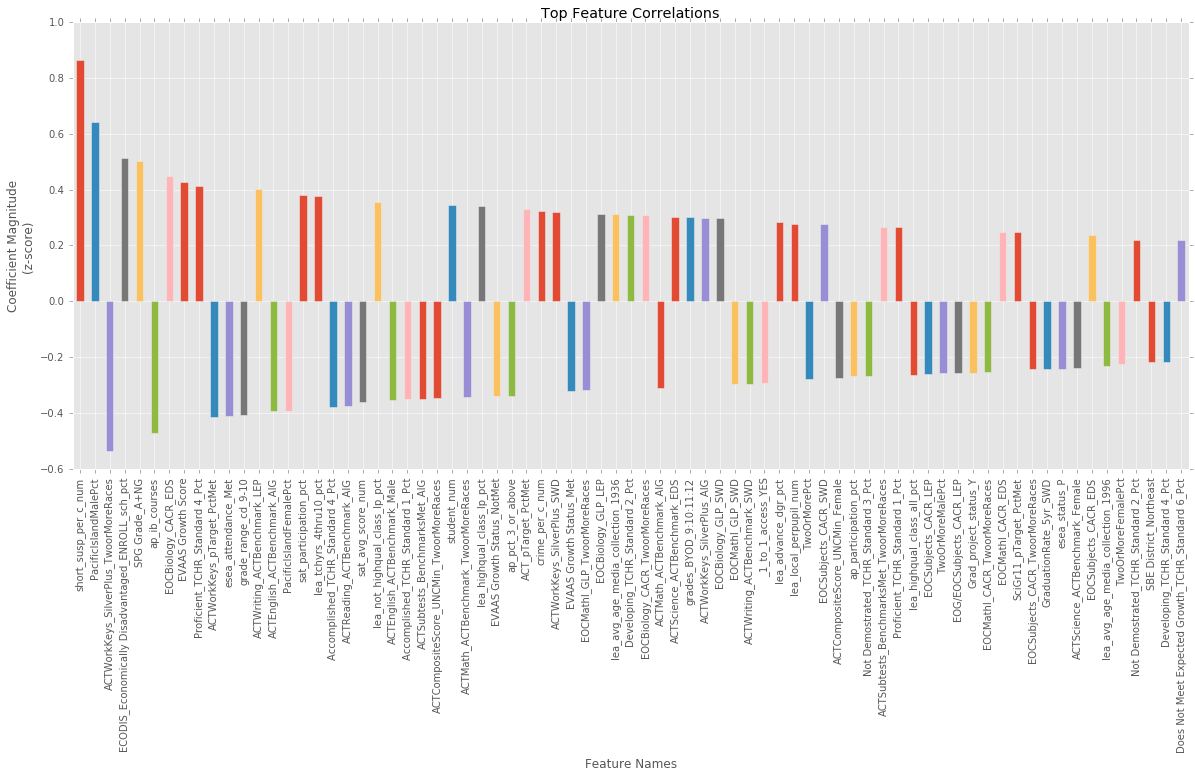

In [28]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

wt_plt_df = linreg_ft_imp_df.head(75)

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='bar', figsize=(20,8))

ax.set_title("Top Feature Correlations")
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()

## Feature Importance Using Recursive Feature Elimination
**Please see the following documentation for this section**
* http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
* http://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html
* http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV
* https://www.kaggle.com/arthurtok/feature-ranking-rfe-random-forest-linear-models

In [29]:
#Convert Y to the top performing binary response 
Y = Y_MinorityPct >= 0.9

In [30]:
from sklearn.feature_selection import RFECV

#Create a regression estimator with best parameters for cross validation
classifierEst = regGridSearch.best_estimator_

rfecv = RFECV(estimator=classifierEst, step=1, cv=cv, scoring='accuracy')
rfecv.fit(X_highSchools, Y)

RFECV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
   estimator=LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False),
   n_jobs=1, scoring='accuracy', step=1, verbose=0)

Optimal number of features : 219


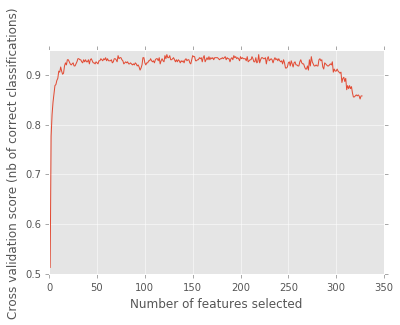

In [31]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [32]:
#Plot the RFE Rankings
plt.style.use('ggplot')

rfe_ft_imp_df = pd.DataFrame({'feature_names':X_highSchools.columns, 'weights':rfecv.grid_scores_})
rfe_ft_imp_df.sort_values(by='weights', inplace=True, ascending=False )

top50features = rfe_ft_imp_df.head(50)

top50features

,feature_names,weights
122,ACTWorkKeys_SilverPlus_AIG,0.941667
218,Distinguished_TCHR_Standard 5_Pct,0.941667
149,univ_college_courses,0.939583
161,short_susp_per_c_num,0.939583
71,ACTWriting_ACTBenchmark_EDS,0.939583
192,lea_1yr_tchr_trnovr_pct,0.939583
120,ACTScience_ACTBenchmark_AIG,0.939583
125,EOCEnglish2_CACR_AIG,0.939583
273,Math SPG Grade_C,0.937500
194,lea_highqual_class_pct,0.937500
